Emergent Hierarchical Representations in Quantized Latent Spaces





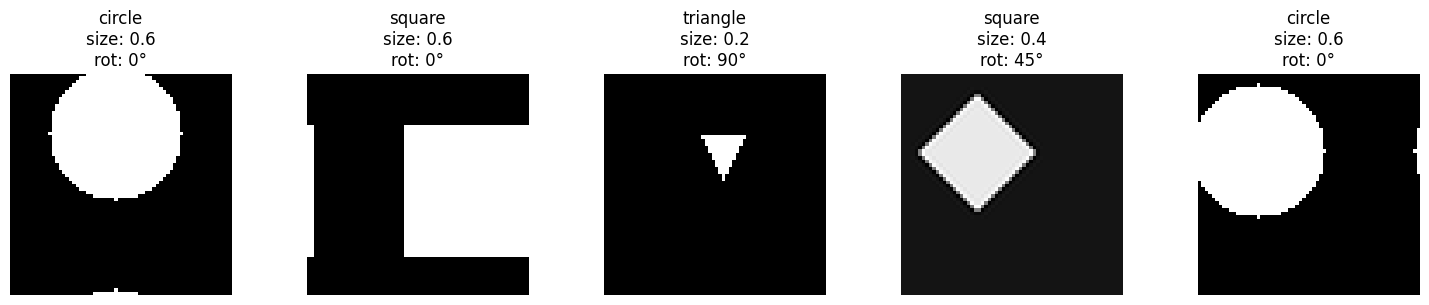

In [ ]:
#Simple Shape Dataset Generator

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class ShapeParams:
    shape_type: str  # 'triangle', 'square', 'circle'
    size: float      # 0.1 to 1.0
    rotation: float  # 0 to 360 degrees
    position: Tuple[float, float]  # (x, y) in -1 to 1 range

class ShapeDataset:
    def __init__(self, image_size=64):
        self.image_size = image_size
        self.shapes = ['triangle', 'square', 'circle']
        self.sizes = [0.2, 0.4, 0.6]  # Start with discrete sizes
        self.rotations = [0, 45, 90]   # Start with discrete rotations

    def generate_shape(self, params: ShapeParams) -> np.ndarray:
        """Generate a binary image of a shape with given parameters."""
        img = np.zeros((self.image_size, self.image_size))
        center = (self.image_size // 2, self.image_size // 2)
        radius = int(params.size * self.image_size // 2)

        if params.shape_type == 'circle':
            y, x = np.ogrid[-center[0]:self.image_size-center[0],
                           -center[1]:self.image_size-center[1]]
            mask = x*x + y*y <= radius*radius
            img[mask] = 1

        elif params.shape_type == 'square':
            x1 = center[0] - radius
            y1 = center[1] - radius
            x2 = center[0] + radius
            y2 = center[1] + radius
            img[x1:x2, y1:y2] = 1

        elif params.shape_type == 'triangle':
            height = radius * 2
            base = radius * 2
            x = center[0]
            y = center[1]

            triangle = np.array([
                [x, y - height//2],
                [x - base//2, y + height//2],
                [x + base//2, y + height//2]
            ])

            from skimage.draw import polygon
            rr, cc = polygon(triangle[:, 0], triangle[:, 1])
            valid_idx = (rr >= 0) & (rr < self.image_size) & \
                       (cc >= 0) & (cc < self.image_size)
            img[rr[valid_idx], cc[valid_idx]] = 1

        # Apply rotation
        if params.rotation != 0:
            from scipy.ndimage import rotate
            img = rotate(img, params.rotation, reshape=False)

        # Apply position offset
        offset_x = int(params.position[0] * self.image_size // 4)
        offset_y = int(params.position[1] * self.image_size // 4)
        img = np.roll(img, offset_x, axis=0)
        img = np.roll(img, offset_y, axis=1)

        return img

    def generate_batch(self, batch_size: int) -> Tuple[np.ndarray, List[ShapeParams]]:
        """Generate a batch of shapes with random parameters."""
        images = np.zeros((batch_size, self.image_size, self.image_size))
        params_list = []

        for i in range(batch_size):
            params = ShapeParams(
                shape_type=np.random.choice(self.shapes),
                size=np.random.choice(self.sizes),
                rotation=np.random.choice(self.rotations),
                position=(np.random.uniform(-1, 1), np.random.uniform(-1, 1))
            )
            images[i] = self.generate_shape(params)
            params_list.append(params)

        return images, params_list

    def visualize_batch(self, images: np.ndarray, params_list: List[ShapeParams],
                       num_samples: int = 5):
        """Visualize a subset of the generated shapes."""
        fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))
        for i in range(num_samples):
            axes[i].imshow(images[i], cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f"{params_list[i].shape_type}\n"
                            f"size: {params_list[i].size:.1f}\n"
                            f"rot: {params_list[i].rotation}°")
        plt.tight_layout()
        return fig

# Example usage
if __name__ == "__main__":
    dataset = ShapeDataset(image_size=64)
    images, params = dataset.generate_batch(batch_size=10)
    dataset.visualize_batch(images, params)
    plt.show()

Training on device: cuda
Epoch [5/20], Loss: 0.1057, Recon Loss: 0.0162, VQ Loss: 0.0895
Epoch [10/20], Loss: 0.0260, Recon Loss: 0.0108, VQ Loss: 0.0153
Epoch [15/20], Loss: 0.0211, Recon Loss: 0.0092, VQ Loss: 0.0119
Epoch [20/20], Loss: 0.0181, Recon Loss: 0.0077, VQ Loss: 0.0104


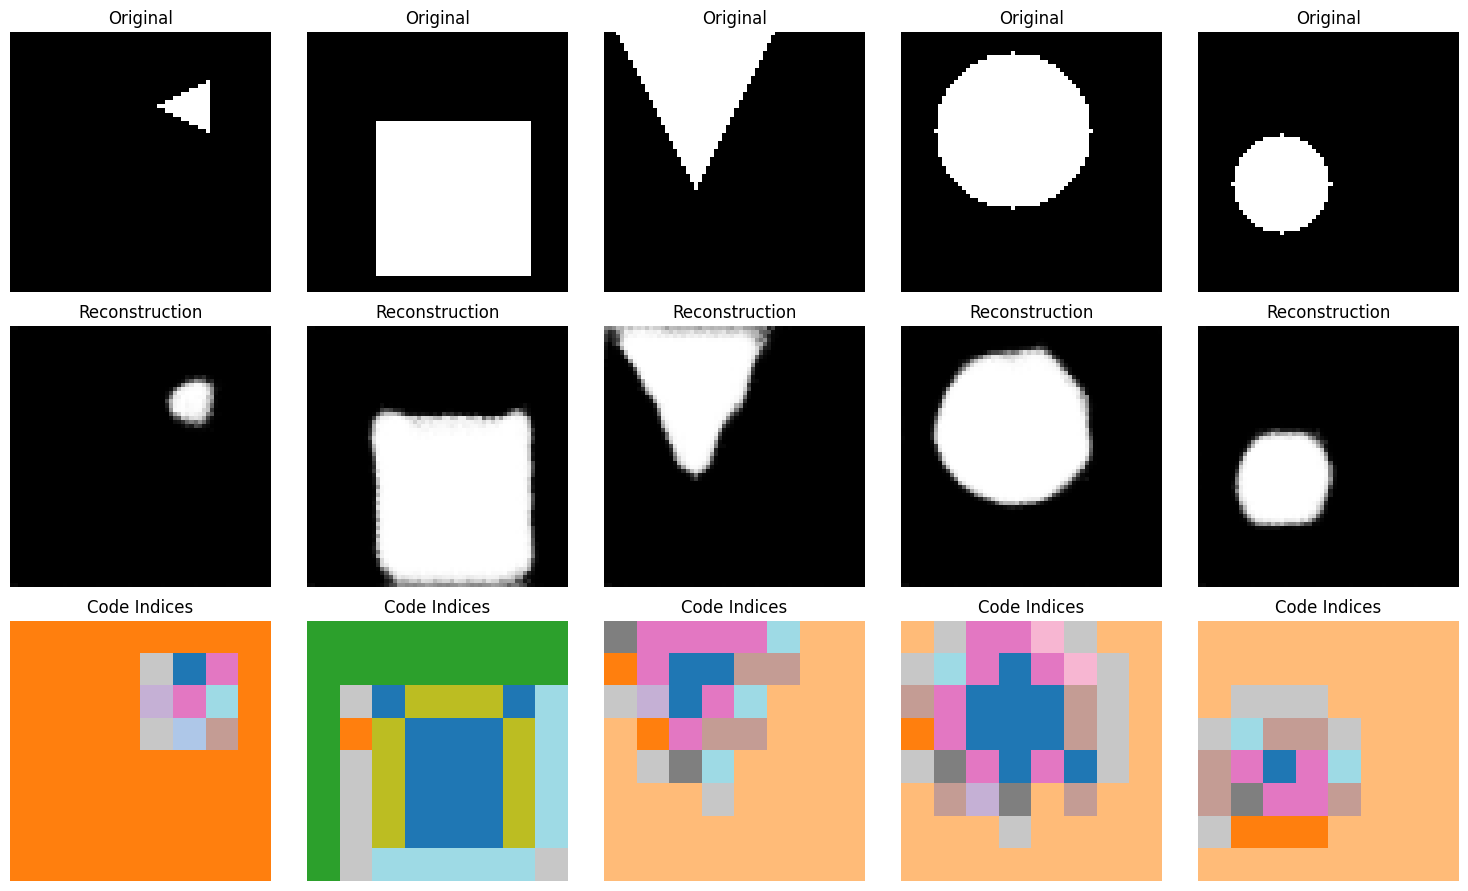

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader

class ShapeDatasetTorch(Dataset):
    def __init__(self, num_samples=1000, image_size=64):
        self.shape_gen = ShapeDataset(image_size=image_size)
        self.images, _ = self.shape_gen.generate_batch(num_samples)
        self.images = torch.FloatTensor(self.images)
        self.image_size = image_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx].unsqueeze(0)  # Add channel dimension

class CNNEncoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(64, latent_dim, kernel_size=4, stride=2, padding=1),  # 8x8
        )

    def forward(self, x):
        return self.encoder(x)

class CNNDecoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=16, commitment_cost=0.25):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def forward(self, inputs):
        # Convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1)
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.reshape(-1, self.embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize
        quantized = torch.matmul(encodings, self.embedding.weight)
        quantized = quantized.reshape(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()  # Straight through estimator

        # Convert quantized from BHWC -> BCHW
        return quantized.permute(0, 3, 1, 2), loss, encoding_indices.reshape(input_shape[:-1])

class VQVAE(nn.Module):
    def __init__(self, latent_dim=16, num_embeddings=512, commitment_cost=0.25):
        super().__init__()
        self.encoder = CNNEncoder(latent_dim=latent_dim)
        self.vector_quantizer = VectorQuantizer(
            num_embeddings=num_embeddings,
            embedding_dim=latent_dim,
            commitment_cost=commitment_cost
        )
        self.decoder = CNNDecoder(latent_dim=latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        z_q, vq_loss, indices = self.vector_quantizer(z)
        x_recon = self.decoder(z_q)
        return x_recon, vq_loss, indices

def train_vqvae(model, train_loader, num_epochs=20, learning_rate=1e-3, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device: {device}")

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model = model.to(device)

    history = {'total_loss': [], 'recon_loss': [], 'vq_loss': []}

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        epoch_recon_loss = 0
        epoch_vq_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            x = batch.to(device)
            x_recon, vq_loss, _ = model(x)

            recon_loss = F.mse_loss(x_recon, x)
            loss = recon_loss + vq_loss

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_vq_loss += vq_loss.item()

        avg_loss = epoch_loss / len(train_loader)
        avg_recon_loss = epoch_recon_loss / len(train_loader)
        avg_vq_loss = epoch_vq_loss / len(train_loader)

        history['total_loss'].append(avg_loss)
        history['recon_loss'].append(avg_recon_loss)
        history['vq_loss'].append(avg_vq_loss)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Loss: {avg_loss:.4f}, '
                  f'Recon Loss: {avg_recon_loss:.4f}, '
                  f'VQ Loss: {avg_vq_loss:.4f}')

    return model, history

def visualize_results(model, test_images, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    with torch.no_grad():
        test_batch = test_images[:5].to(device)
        reconstructions, _, indices = model(test_batch)

        # Plot
        fig, axes = plt.subplots(3, 5, figsize=(15, 9))

        for i in range(5):
            # Original
            axes[0, i].imshow(test_batch[i, 0].cpu(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title('Original')

            # Reconstruction
            axes[1, i].imshow(reconstructions[i, 0].cpu(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title('Reconstruction')

            # Code usage
            axes[2, i].imshow(indices[i].cpu(), cmap='tab20')
            axes[2, i].axis('off')
            axes[2, i].set_title('Code Indices')

        plt.tight_layout()
        plt.show()

# Example usage
if __name__ == "__main__":
    # Create dataset and dataloader
    dataset = ShapeDatasetTorch(num_samples=1000)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Initialize model
    model = VQVAE(latent_dim=128, num_embeddings=256)

    # Train model
    trained_model, history = train_vqvae(model, dataloader, num_epochs=20)

    # Visualize results
    test_images = next(iter(dataloader))
    visualize_results(trained_model, test_images)

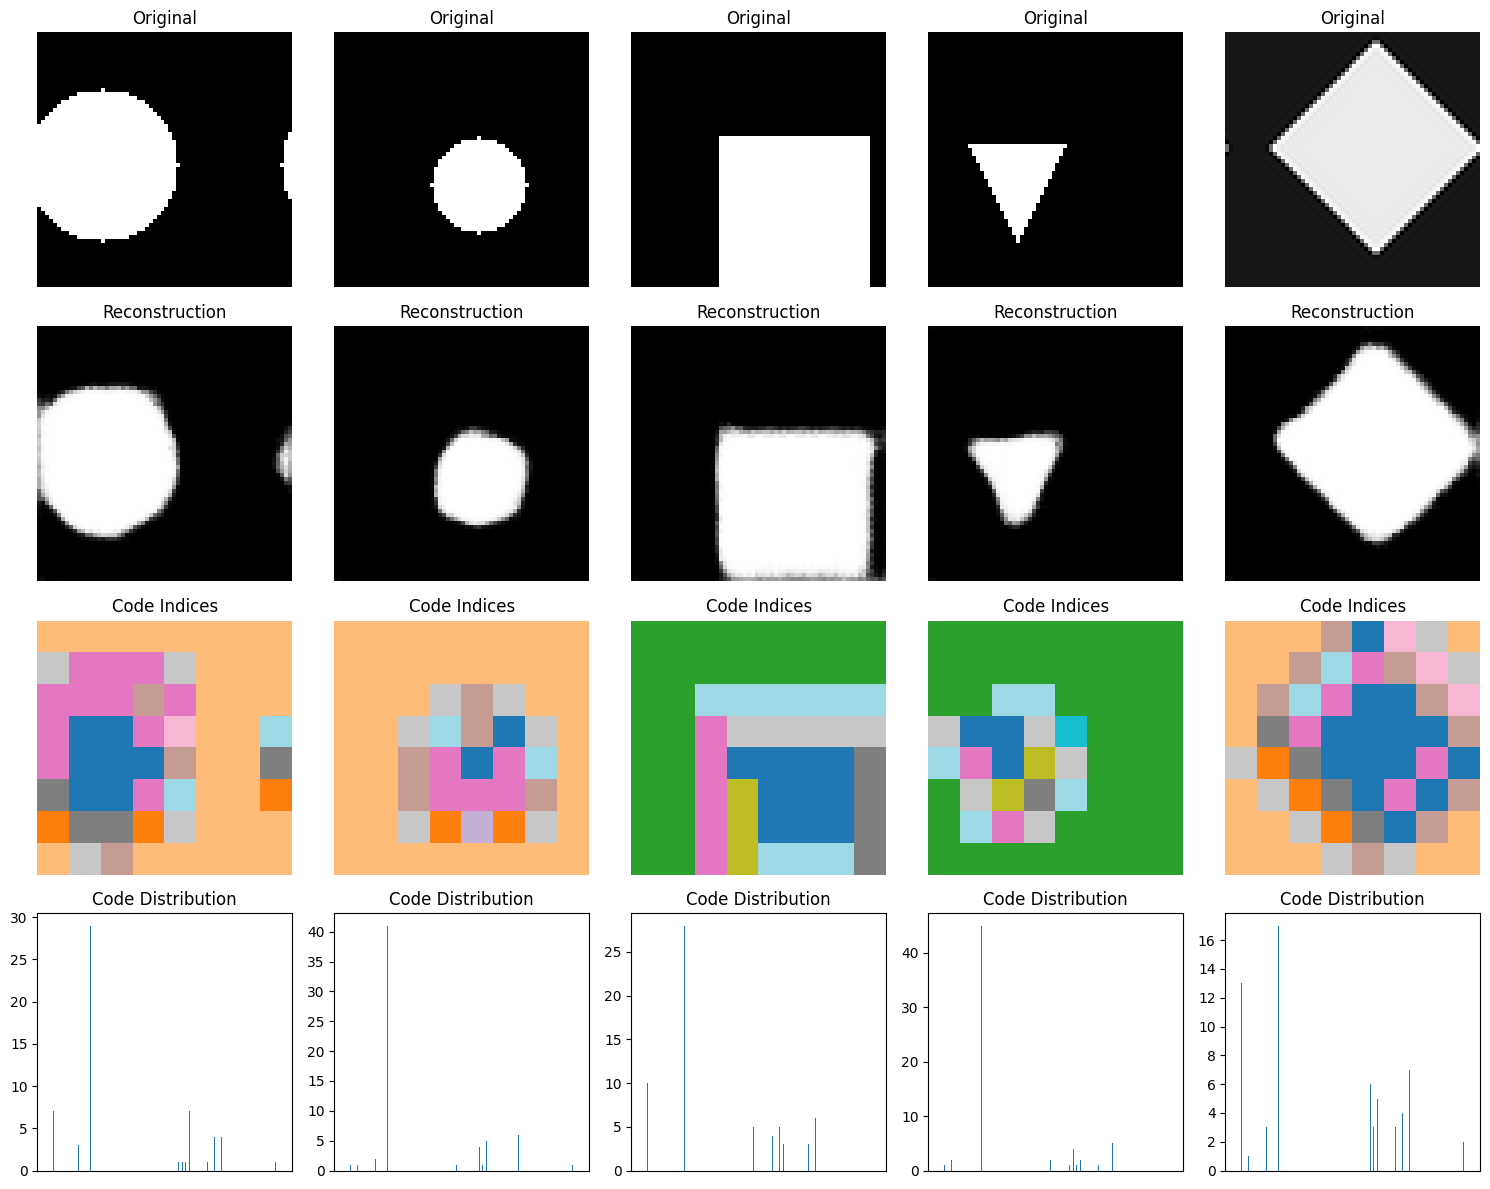

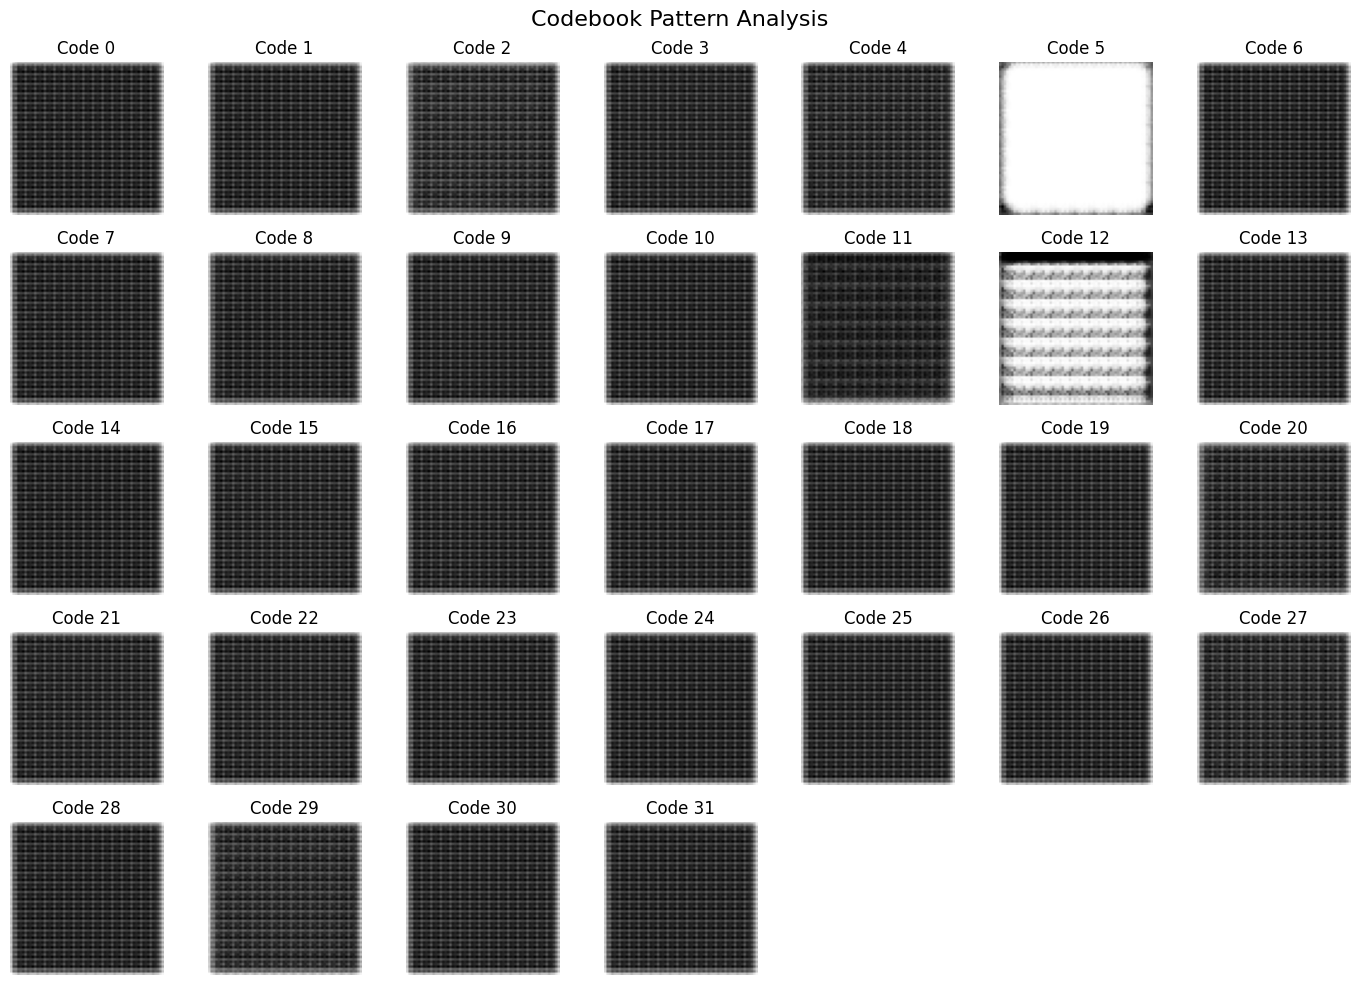

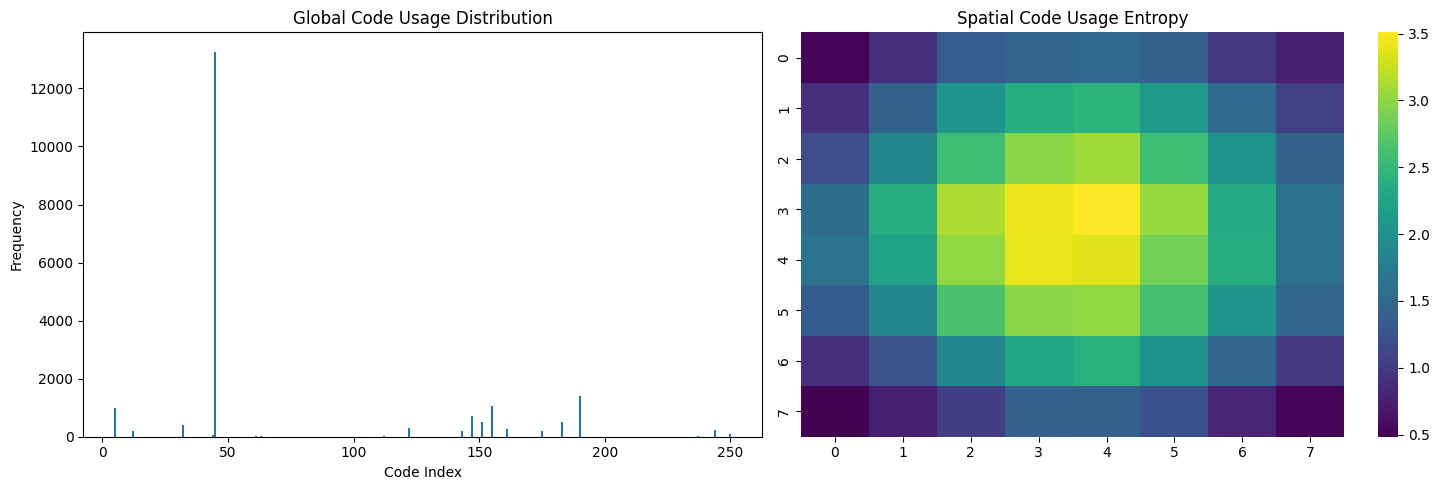

Total number of codes: 256
Number of codes used: 21 (8.2%)
Most common codes: [(45, 13269), (190, 1398), (155, 1061), (5, 975), (147, 721)]


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

def visualize_spatial_codes(model, test_images, device, num_samples=5):
    """
    Visualize how spatial codes are being used across different images.
    Shows original, reconstruction, and code usage map.
    """
    model.eval()
    with torch.no_grad():
        x = test_images[:num_samples].to(device)
        z = model.encoder(x)
        z_q, _, indices = model.vector_quantizer(z)
        x_recon = model.decoder(z_q)

        # Create visualization
        fig, axes = plt.subplots(4, num_samples, figsize=(num_samples * 3, 12))

        for i in range(num_samples):
            # Original
            axes[0, i].imshow(x[i, 0].cpu(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title('Original')

            # Reconstruction
            axes[1, i].imshow(x_recon[i, 0].cpu(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title('Reconstruction')

            # Code usage map
            im = axes[2, i].imshow(indices[i].cpu(), cmap='tab20')
            axes[2, i].axis('off')
            axes[2, i].set_title('Code Indices')

            # Code usage histogram
            axes[3, i].hist(indices[i].cpu().numpy().flatten(),
                          bins=range(model.vector_quantizer.num_embeddings + 1),
                          align='left')
            axes[3, i].set_title('Code Distribution')
            axes[3, i].set_xticks([])

        plt.tight_layout()
        plt.show()

def analyze_codebook_patterns(model, device, spatial_size=8):
    """
    Visualize what patterns each code in the codebook represents.
    Creates a single-code reconstruction for each codebook entry.
    """
    model.eval()
    with torch.no_grad():
        # Number of codes to display (limit to a reasonable number)
        num_codes = min(32, model.vector_quantizer.num_embeddings)

        # Create a batch where each spatial location uses the same code
        rows = int(np.sqrt(num_codes))
        cols = (num_codes + rows - 1) // rows

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        axes = axes.flatten() if num_codes > 1 else [axes]

        for code_idx in range(num_codes):
            # Create a spatial grid of the same code
            indices = torch.full((1, spatial_size, spatial_size), code_idx,
                               device=device)

            # Convert to one-hot
            one_hot = torch.zeros(1, spatial_size, spatial_size,
                                model.vector_quantizer.num_embeddings,
                                device=device)
            one_hot.scatter_(-1, indices.unsqueeze(-1), 1)

            # Get embedding
            quantized = torch.matmul(one_hot,
                                   model.vector_quantizer.embedding.weight)

            # Reshape to match expected dimensions (BCHW)
            quantized = quantized.permute(0, 3, 1, 2)

            # Decode
            reconstruction = model.decoder(quantized)

            # Plot
            axes[code_idx].imshow(reconstruction[0, 0].cpu(), cmap='gray')
            axes[code_idx].axis('off')
            axes[code_idx].set_title(f'Code {code_idx}')

        # Remove empty subplots
        for idx in range(num_codes, len(axes)):
            fig.delaxes(axes[idx])

        plt.suptitle('Codebook Pattern Analysis', fontsize=16)
        plt.tight_layout()
        plt.show()

def analyze_code_usage_stats(model, dataloader, device, num_batches=10):
    """
    Analyze the statistical usage of codes across the dataset.
    Shows global usage patterns and spatial preferences.
    """
    model.eval()
    global_code_counts = Counter()
    spatial_code_counts = {}  # Track code usage at each spatial position

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_batches:
                break

            x = batch.to(device)
            z = model.encoder(x)
            _, _, indices = model.vector_quantizer(z)

            # Update global counts
            global_code_counts.update(indices.cpu().numpy().flatten())

            # Update spatial counts
            for h in range(indices.shape[1]):
                for w in range(indices.shape[2]):
                    pos = (h, w)
                    if pos not in spatial_code_counts:
                        spatial_code_counts[pos] = Counter()
                    spatial_code_counts[pos].update(
                        indices[:, h, w].cpu().numpy().flatten())

    # Create visualizations
    fig = plt.figure(figsize=(15, 5))

    # Plot 1: Global code usage
    plt.subplot(121)
    codes, counts = zip(*sorted(global_code_counts.items()))
    plt.bar(codes, counts)
    plt.xlabel('Code Index')
    plt.ylabel('Frequency')
    plt.title('Global Code Usage Distribution')

    # Plot 2: Spatial code usage heatmap
    plt.subplot(122)
    spatial_size = int(np.sqrt(len(spatial_code_counts)))
    heatmap = np.zeros((spatial_size, spatial_size))

    for (h, w), counter in spatial_code_counts.items():
        # Calculate entropy of code usage at this position
        total = sum(counter.values())
        probs = [count/total for count in counter.values()]
        entropy = -sum(p * np.log2(p) for p in probs if p > 0)
        heatmap[h, w] = entropy

    sns.heatmap(heatmap, cmap='viridis')
    plt.title('Spatial Code Usage Entropy')

    plt.tight_layout()
    plt.show()

    # Print statistics
    total_codes = model.vector_quantizer.num_embeddings
    used_codes = len(global_code_counts)
    print(f"Total number of codes: {total_codes}")
    print(f"Number of codes used: {used_codes} ({100*used_codes/total_codes:.1f}%)")
    print(f"Most common codes: {Counter(global_code_counts).most_common(5)}")

# Example usage
if __name__ == "__main__":
    # Assuming model is already trained
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Get some test images
    test_images = next(iter(dataloader))

    # Visualize spatial code usage
    visualize_spatial_codes(model, test_images, device)

    # Analyze codebook patterns
    analyze_codebook_patterns(model, device)

    # Analyze code usage statistics
    analyze_code_usage_stats(model, dataloader, device)